# JIRA Trend Analysis

This notebook analyzes and visualizes project progress from JIRA data.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import configparser
from jira import JIRA
import numpy as np
from matplotlib.widgets import Cursor
import matplotlib.dates as mdates

In [13]:
def read_config():
    config = configparser.ConfigParser()
    config.read('jira.config')
    return {
        'username': config['JIRA']['username'],
        'api_key': config['JIRA']['api_key'],
        'server_url': config['JIRA']['server_url']
    }

In [14]:
def get_jira_data():
    config = read_config()
    jira = JIRA(config['server_url'], 
                basic_auth=(config['username'], config['api_key']))
    
    jql_query = '''
    project = "DS" 
    and (status was in ("To Do", "In Progress", "In Review") after "2025-03-11"
         OR status changed to "Done" after "2025-03-11")
    and status != "Rejected"
    and type not in ("Feature", "Portfolio Epic")
    and (
        (issueKey in portfolioChildIssuesOf(DS-9557) 
        OR issueKey in portfolioChildIssuesOf(DS-12475)
        OR issueKey in (DS-9557, DS-12475))
        OR 
        (parent in (DS-9557, DS-12475))
    )
    and parent not in (DS-12484, DS-9866, DS-12111, DS-9009)   
    ORDER BY statusCategory ASC'''
    issues = jira.search_issues(jql_query, maxResults=1000, expand='changelog')
    
    # Dictionary to store estimate changes over time
    estimate_changes = {}
    
    # Dictionary to track current estimates for each issue
    current_estimates = {}
    
    for issue in issues:
        # Get current estimate
        current_estimate = issue.fields.timeoriginalestimate / (3600 * 8) if issue.fields.timeoriginalestimate else 0
        current_estimates[issue.key] = current_estimate

        # Initialize the estimate for this issue at the start date
        if datetime(2025, 3, 12).date() not in estimate_changes:
            estimate_changes[datetime(2025, 3, 12).date()] = {}
        estimate_changes[datetime(2025, 3, 12).date()][issue.key] = current_estimate
        
        # Track estimate changes from changelog
        for history in issue.changelog.histories:
            for item in history.items:
                if item.field == 'timeoriginalestimate':
                    # Convert timestamp to date
                    change_date = pd.to_datetime(history.created).date()
                    # Convert seconds to days
                    new_estimate = float(item.toString) / (3600 * 8) if item.toString else 0
                    
                    if change_date not in estimate_changes:
                        estimate_changes[change_date] = {}
                    estimate_changes[change_date][issue.key] = new_estimate
                    current_estimates[issue.key] = new_estimate
    
    # Create DataFrame with all estimate changes
    scope_data = []
    running_estimates = {}
    
    # Sort dates to process them in chronological order
    sorted_dates = sorted(estimate_changes.keys())
    
    for date in sorted_dates:
        # Update running estimates with changes for this date
        for issue_key, new_estimate in estimate_changes[date].items():
            running_estimates[issue_key] = new_estimate
        
        # Calculate total from running estimates
        total = sum(running_estimates.values())
        scope_data.append({
            'date': date,
            'total_estimate': total
        })
    
    scope_df = pd.DataFrame(scope_data)
    scope_df = scope_df.sort_values('date')
    
    # Create date range for the entire project period
    start_date = datetime(2025, 3, 12).date()
    end_date = datetime(2025, 5, 6).date()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D').date
    
    # Create a complete dataset with all dates
    complete_scope_df = pd.DataFrame({'date': date_range})
    complete_scope_df = complete_scope_df.merge(scope_df, on='date', how='left')
    
    # Forward fill the total estimate to maintain the current value until it changes
    complete_scope_df['total_estimate'] = complete_scope_df['total_estimate'].ffill()
    
    # Get current data for completed work
    data = []
    for issue in issues:
        originalestimate_days = issue.fields.timeoriginalestimate / (3600 * 8) if issue.fields.timeoriginalestimate else 0
        duedate = pd.to_datetime(issue.fields.duedate).date() if issue.fields.duedate and issue.fields.status.name == "Done" else None
        data.append({
            'key': issue.key,
            'duedate': duedate,
            'originalestimate': originalestimate_days
        })
    
    return pd.DataFrame(data), complete_scope_df

In [15]:
# Fetch data from JIRA
df, scope_df = get_jira_data()

# Display the data
print("Completed Work Data:")
display(df)
print("\nScope Data:")
display(scope_df)

Completed Work Data:


,key,duedate,originalestimate
0,DS-13211,None,2.0
1,DS-13210,None,2.0
2,DS-13209,None,2.0
3,DS-13208,None,2.0
4,DS-13207,None,2.0
5,DS-12571,None,3.0
6,DS-12570,None,3.0
7,DS-12540,None,0.0
8,DS-12528,None,3.0
9,DS-12389,None,3.0



Scope Data:


,date,total_estimate
0,2025-03-12,66.0
1,2025-03-13,66.0
2,2025-03-14,66.0
3,2025-03-15,66.0
4,2025-03-16,66.0
5,2025-03-17,66.0
6,2025-03-18,66.0
7,2025-03-19,66.0
8,2025-03-20,66.0
9,2025-03-21,66.0


In [16]:
%matplotlib widget

In [17]:
def create_chart(df, scope_df):
    # Convert duedate to datetime (date-only)
    df['duedate'] = pd.to_datetime(df['duedate'])
    
    # Filter out issues without due dates
    df_with_dates = df.dropna(subset=['duedate'])
    
    # Group by duedate and sum originalestimate
    daily_estimates = df_with_dates.groupby('duedate')['originalestimate'].sum().reset_index()
    
    # Sort by date
    daily_estimates = daily_estimates.sort_values('duedate')
    
    # Calculate cumulative sum
    daily_estimates['cumulative_sum'] = daily_estimates['originalestimate'].cumsum()
    
    # Create date range for the entire project period
    start_date = datetime(2025, 3, 12)
    end_date = datetime(2025, 5, 6)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create a complete dataset with all dates
    complete_df = pd.DataFrame({'duedate': date_range})
    
    # Convert daily_estimates duedate to datetime64[ns]
    daily_estimates['duedate'] = pd.to_datetime(daily_estimates['duedate'])
    
    complete_df = complete_df.merge(daily_estimates, on='duedate', how='left')
    
    # Fill NaN values with 0 for originalestimate
    complete_df['originalestimate'] = complete_df['originalestimate'].fillna(0)
    
    # Calculate cumulative sum starting from 0
    complete_df['cumulative_sum'] = complete_df['originalestimate'].cumsum()
    
    # Calculate when team would complete today's scope
    today_scope = scope_df['total_estimate'].iloc[-1]
    hours_per_day = 12.8
    days_needed = (today_scope * 8) / hours_per_day  # Convert scope days to hours, then divide by daily hours
    completion_date = start_date + timedelta(days=days_needed)  # Use float instead of int
    print(f'scope: {today_scope}, days_needed: {days_needed}, completion_date: {completion_date}')
    
    # Calculate today's expected progress
    today = datetime.now()
    work_days = (today - start_date).total_seconds() / (3600 * 24)
    expected_progress = (work_days * hours_per_day) / 8  # Convert hours to days

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the cumulative line
    line, = ax.plot(complete_df['duedate'], complete_df['cumulative_sum'], 
                    label='Completed', color='blue')
    ax.fill_between(complete_df['duedate'], complete_df['cumulative_sum'], 
                    alpha=0.3, color='blue')
    
    # Plot the scope line
    scope_line, = ax.plot(scope_df['date'], scope_df['total_estimate'], 
                         label=f'Total Scope ({scope_df["total_estimate"].max():.1f} days)', color='green', linestyle='--')
    ax.fill_between(scope_df['date'], scope_df['total_estimate'], 
                    alpha=0.1, color='green')
    
    # Plot completion point
    ax.scatter(completion_date, today_scope, color='purple', s=150, 
               marker='*', label=f'Ideal Done ({completion_date.strftime("%Y-%m-%d %H:%M")})')
    
    # Draw dashed purple line from start to completion
    ax.plot([start_date, completion_date], [0, today_scope], 
            color='purple', linestyle='--', alpha=0.5)
    
    # Plot today's expected progress
    ax.scatter(today, expected_progress, color='red', s=100, 
               label=f'Ideal Today ({expected_progress:.1f} days)')
    
    # Customize the plot
    ax.set_title('Project Progress vs. Estimate')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    
    # Set y-axis maximum to the larger of total estimate days or current scope
    max_y = max(df['originalestimate'].sum(), scope_df['total_estimate'].max(), expected_progress) + 2
    ax.set_ylim(0, max_y)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Create annotation for tooltips
    line_annot = ax.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                           bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
    line_annot.set_visible(False)
    
    scope_annot = ax.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                            bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
    scope_annot.set_visible(False)
    
    completion_annot = ax.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                                 bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
    completion_annot.set_visible(False)
    
    progress_annot = ax.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                               bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
    progress_annot.set_visible(False)
    
    def update_annot(event):
        if event.inaxes == ax:            
            # Find the nearest point
            x = mdates.num2date(event.xdata)
            x = x.replace(tzinfo=None)  # Make timezone-naive
            
            # Find the index of the nearest date
            idx = (complete_df['duedate'].dt.tz_localize(None) - x).abs().idxmin()
            
            # Get the data for that date
            date = complete_df.loc[idx, 'duedate']
            value = complete_df.loc[idx, 'cumulative_sum']
            
            # Convert dates to numerical values for interpolation
            x_num = mdates.date2num(date)
            xdata_nums = mdates.date2num(complete_df['duedate'])
            
            # Calculate the distance from the mouse to the line at this x position
            y_line = np.interp(x_num, xdata_nums, complete_df['cumulative_sum'])
            distance = abs(event.ydata - y_line)
            
            # Calculate distance to scope line
            scope_x = mdates.date2num(date)
            scope_y = np.interp(scope_x, mdates.date2num(scope_df['date']), scope_df['total_estimate'])
            scope_distance = abs(event.ydata - scope_y)
            
            # Calculate distance to completion point
            completion_x = mdates.date2num(completion_date)
            completion_distance = np.sqrt((event.xdata - completion_x)**2 + (event.ydata - today_scope)**2)
            
            # Calculate distance to progress point
            progress_x = mdates.date2num(today)
            progress_distance = np.sqrt((event.xdata - progress_x)**2 + (event.ydata - expected_progress)**2)
            
            # Only show line tooltip if within 5% of the y-axis range
            y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
            threshold = y_range * 0.01
            
            if distance < threshold:
                # Update line annotation
                line_annot.xy = (x_num, value)
                line_annot.set_text(f"{date.strftime('%Y-%m-%d')}\n{value:.1f} days")
                line_annot.set_visible(True)
                scope_annot.set_visible(False)
                completion_annot.set_visible(False)
                progress_annot.set_visible(False)
            elif scope_distance < threshold:
                # Update scope annotation
                scope_annot.xy = (scope_x-6.5, scope_y-7)
                scope_annot.set_text(f"Total Scope\n{scope_y:.1f} days")
                scope_annot.set_visible(True)
                line_annot.set_visible(False)
                completion_annot.set_visible(False)
                progress_annot.set_visible(False)
            elif completion_distance < threshold:
                # Update completion annotation
                completion_annot.xy = (completion_x, today_scope)
                completion_annot.set_text(f"Est Completion\n{completion_date.strftime('%Y-%m-%d %H:%M')}")
                completion_annot.set_visible(True)
                line_annot.set_visible(False)
                scope_annot.set_visible(False)
                progress_annot.set_visible(False)
            elif progress_distance < threshold:
                # Update progress annotation
                progress_annot.xy = (progress_x, expected_progress)
                progress_annot.set_text(f"Today's Expected\n{expected_progress:.1f} days")
                progress_annot.set_visible(True)
                line_annot.set_visible(False)
                scope_annot.set_visible(False)
                completion_annot.set_visible(False)
            else:
                line_annot.set_visible(False)
                scope_annot.set_visible(False)
                completion_annot.set_visible(False)
                progress_annot.set_visible(False)
            
            fig.canvas.draw_idle()
        else:
            line_annot.set_visible(False)
            scope_annot.set_visible(False)
            completion_annot.set_visible(False)
            progress_annot.set_visible(False)
            fig.canvas.draw_idle()
    
    # Connect the event handler
    fig.canvas.mpl_connect('motion_notify_event', update_annot)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

scope: 66.0, days_needed: 41.25, completion_date: 2025-04-22 06:00:00


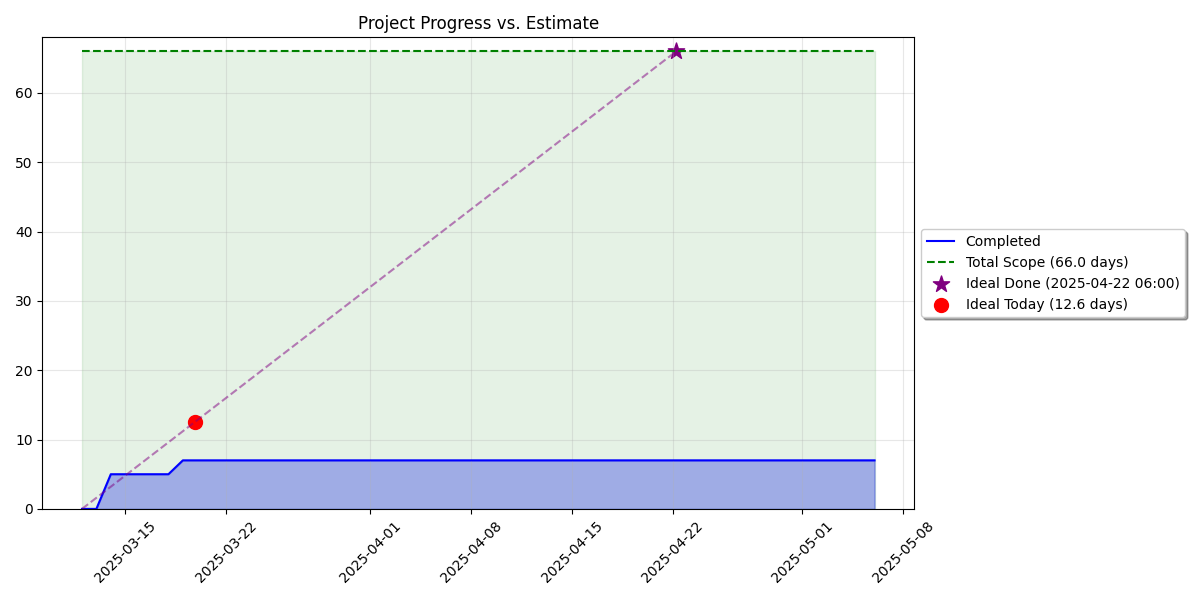

In [18]:
# Create the chart
create_chart(df, scope_df)